## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [2]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

--2021-11-26 16:49:59--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2021-11-26 16:50:00--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc78e3d93fc4bc7d785f459984ab.dl.dropboxusercontent.com/cd/0/inline/Bau0GEgXa0wr7FKZ1QzK2H4LhWfE7_vL1YaLN0RzGbvIcoAl7RIVT9jCHjTrJvslldzwkB_4xGQyGhVcftyP98_y0sYaNfxestgVSIZ93jmCpD3n4j_Q6rHNmGHaRwcQutthaY2xaO_l6PSL6qMdoZrl/file# [following]
--2021-11-26 16:50:00--  https://uc78e3d93fc4bc7d785f459984ab.dl.dropboxusercontent.com/cd/0/inline/Bau0GEgXa0wr7FKZ1QzK2H4LhWfE7_vL1YaLN0RzGbvIcoAl7RIVT9jCHjTrJvslldzwkB_4xGQyGh

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

1. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

In [2]:
N=200000
f=pd.read_csv('/home/reza/data/data_000637.txt.1',nrows=N)
df=pd.DataFrame(f)
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
199995,1,0,139,3869202157,76,0
199996,1,0,62,3869202157,76,2
199997,1,1,2,3869202157,94,15
199998,1,1,1,3869202157,96,13


2. Find out the number of BX in a ORBIT (the value 'x').

In [3]:
x = df["BX_COUNTER"].max()+1 #something like second in clock we never see the 12:26:60
                               # we have 12:27:59, so we add 1 to the mux of BX_COUNTER.
                               #and this x is that we can see in the datas and mayby the real x 
                               #is => the x we see in datas.
x

3564

3. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

In [4]:
%time data=pd.read_csv('/home/reza/data/data_000637.txt.1')

CPU times: user 360 ms, sys: 55.9 ms, total: 416 ms
Wall time: 415 ms


4. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

In [5]:
df["time(s)"]=((df["TDC_MEAS"]*(25/30)) + (df["BX_COUNTER"]*25) + (df["ORBIT_CNT"]*(3564)*25))*(10**-9)
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time(s)
0,1,0,123,3869200167,2374,26,344745.734939
1,1,0,124,3869200167,2374,27,344745.734939
2,1,0,63,3869200167,2553,28,344745.734944
3,1,0,64,3869200167,2558,19,344745.734944
4,1,0,64,3869200167,2760,25,344745.734949
...,...,...,...,...,...,...,...
199995,1,0,139,3869202157,76,0,344745.912191
199996,1,0,62,3869202157,76,2,344745.912191
199997,1,1,2,3869202157,94,15,344745.912191
199998,1,1,1,3869202157,96,13,344745.912191


5. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

In [7]:
r=np.random.randint(2,size=200000)
df['HEAD']=r
df


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time(s)
0,0,0,123,3869200167,2374,26,344745.734939
1,1,0,124,3869200167,2374,27,344745.734939
2,0,0,63,3869200167,2553,28,344745.734944
3,0,0,64,3869200167,2558,19,344745.734944
4,0,0,64,3869200167,2760,25,344745.734949
...,...,...,...,...,...,...,...
199995,1,0,139,3869202157,76,0,344745.912191
199996,1,0,62,3869202157,76,2,344745.912191
199997,1,1,2,3869202157,94,15,344745.912191
199998,0,1,1,3869202157,96,13,344745.912191


6. Create a new DataFrame that contains only the rows with HEAD=1.

In [8]:
df_h_1=df[df['HEAD'] == 1]
df_h_1

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time(s)
1,1,0,124,3869200167,2374,27,344745.734939
9,1,0,60,3869200167,2788,7,344745.734949
12,1,1,6,3869200167,2792,18,344745.734950
13,1,0,36,3869200167,2791,23,344745.734949
14,1,0,56,3869200167,2789,3,344745.734949
...,...,...,...,...,...,...,...
199990,1,0,74,3869202157,33,11,344745.912190
199992,1,0,64,3869202157,61,24,344745.912190
199995,1,0,139,3869202157,76,0,344745.912191
199996,1,0,62,3869202157,76,2,344745.912191


7. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

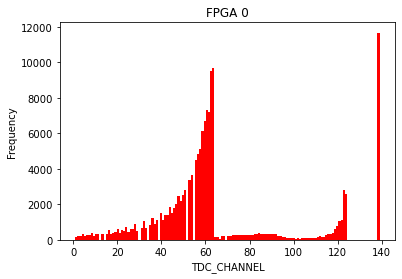

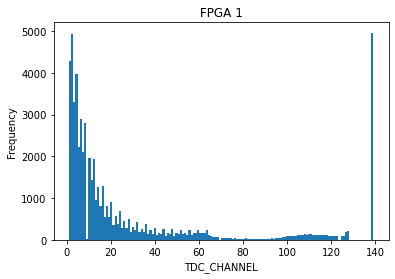

In [9]:
df_f_0=df[df['FPGA'] == 0]
df_f_1=df[df['FPGA'] == 1]

p_0 = df_f_0['TDC_CHANNEL'].plot(kind='hist',bins=140,title='FPGA 0',color='r')
p_0.set(xlabel='TDC_CHANNEL')
plt.show()

p_1 = df_f_1['TDC_CHANNEL'].plot(kind='hist',bins=140,title='FPGA 1')
p_1.set(xlabel='TDC_CHANNEL')
plt.show()

8. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [10]:
n=df.groupby('TDC_CHANNEL').count().sort_values(by="HEAD",ascending=False).head(3)
m=n.reset_index()
print('The noisy channels for all FPGAs:\n',m['TDC_CHANNEL'][0],"\n",m['TDC_CHANNEL'][1],"\n",m['TDC_CHANNEL'][2],"\n")

n_1=df_f_1.groupby('TDC_CHANNEL').count().sort_values(by="HEAD",ascending=False).head(3)
m_1=n_1.reset_index()
print('The noisy channels for 1 FPGAs:\n',m_1['TDC_CHANNEL'][0],"\n",m_1['TDC_CHANNEL'][1],"\n",m_1['TDC_CHANNEL'][2],"\n")

n_0=df_f_0.groupby('TDC_CHANNEL').count().sort_values(by="HEAD",ascending=False).head(3)
m_0=n_0.reset_index()
print('The noisy channels for 0 FPGAs:\n',m_0['TDC_CHANNEL'][0],"\n",m_0['TDC_CHANNEL'][1],"\n",m_0['TDC_CHANNEL'][2],"\n")

The noisy channels for all FPGAs:
 139 
 64 
 63 

The noisy channels for 1 FPGAs:
 139 
 2 
 1 

The noisy channels for 0 FPGAs:
 139 
 64 
 63 



9. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [11]:
c=df.groupby('ORBIT_CNT').count()
print('There are {} unique orbits.'.format(c.shape[0]),"\n")

df_tdc_139 = df[df['TDC_CHANNEL'] == 139]
print('There are {} unique orbits with at least one measurement from TDC_CHANNEL=139.'.format(df_tdc_139.groupby('ORBIT_CNT').count().shape[0]))

There are 1989 unique orbits. 

There are 1987 unique orbits with at least one measurement from TDC_CHANNEL=139.
